In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from IPython.display import clear_output
from sklearn import preprocessing

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# example of converting an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

from tensorflow.keras.initializers import glorot_uniform
import tensorflow as tf

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

/home/csgrads/samad028/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/csgrads/samad028/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/csgrads/samad028/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/csgrads/samad028

In [2]:
%run paths.py # Load all our paths
%run methods.py # Load all our methods

MODEL_FILE = 'model_cnn_data-1000000_epochs-100'
PREDICTION_MODEL = os.path.join(MODELS_DIR, MODEL_FILE+'.h5')

os.listdir(DATASET_DIR)

['test_images',
 'train_masks.zip',
 'train_images.zip',
 'car_models',
 '.ipynb_checkpoints',
 'car_models_json.zip',
 'personal',
 'car_models.zip',
 'test_masks',
 'train.csv',
 'train_images',
 'test_images.zip',
 'train_masks',
 'camera.zip',
 'sample_submission.csv',
 'car_models_json',
 'test_masks.zip',
 'camera']

In [12]:
def test_images_on_dir(model_h5=PREDICTION_MODEL,images_dir=TEST_IMAGES_DIR,masks_dir=None,detection_probability=50,hide_own_bonnet=True,show_detected_img=False):

    model = tf.keras.models.load_model(model_h5,custom_objects={'GlorotUniform': glorot_uniform()})
    
    testImageIds = os.listdir(images_dir)

    PredictionString = dict()
    
    totalFiles = len(testImageIds)

    for count,ImageIdWithJPG in enumerate(testImageIds):

        ImageId = ImageIdWithJPG.replace(".jpg","")
        
        img_path = os.path.join(images_dir, ImageIdWithJPG)
        
        if masks_dir is not None:
            mask_path = os.path.join(masks_dir, '{}.{}'.format(ImageId, 'jpg'))
        else:
            mask_path = None
        
        image = open_image_preprocessed(img_path,hide_own_bonnet=hide_own_bonnet,mask_path=mask_path)
        detector = detector_imageai("yolo")
        
        output_image_path = os.path.join(DETECTIONS_DIR , "test/"+ImageId+".jpg")

        returned_results = detector.detectCustomObjectsFromImage(
            custom_objects=detector.CustomObjects(car=True),
            input_image=image, 
            input_type="array",
            output_image_path=output_image_path,
            minimum_percentage_probability=detection_probability,
            extract_detected_objects=True)

        detections, objects_path = returned_results

        PredictionString[ImageId] = ""

        eachCarString = []

        for eachObject, eachObjectPath in zip(detections, objects_path):
            ImageIdSubId = ImageId+"-"+str(eachObjectPath.split("objects/")[1].split(".")[0].split("-")[1])

            det = eachObject["box_points"]
            x1, y1, x2, y2 = det[0], det[1], det[2], det[3]
            extra_inputs = [x1, y1, x2, y2]
            temp_array = format_inputs_appended_with_image(ImageIdSubId,extra_inputs,'test')
            temp_array = np.array([temp_array])

            confidence = eachObject["percentage_probability"]/100

            xyz_ypr = model.predict(temp_array).flatten()

            x,y,z,yaw,pitch,roll = xyz_ypr[0],xyz_ypr[1],xyz_ypr[2],xyz_ypr[3],xyz_ypr[4],xyz_ypr[5]

            output_format_list = [yaw, pitch, roll, x, y, z, confidence]

            # Round off 2 decimal places
            output_format_list = [ round(elem, 2) for elem in output_format_list ]

            output_format_str = " ".join(map(str,output_format_list))

            eachCarString.append(output_format_str)
            #print(output_format_str)

        PredictionString[ImageId] = " ".join(eachCarString)

        #print(PredictionString[ImageId])
        
        if show_detected_img:
            returned_image = open_image_preprocessed(output_image_path,hide_own_bonnet=hide_own_bonnet,mask_path=None)
            show_image(img=returned_image,width=15)
        else:
            clear_output(wait=True)
        print(f"{count+1}/{totalFiles} Completed. Just tested Image: {ImageId}")

        """if count>1:
            break"""

    submission = []
    for key,value in PredictionString.items():
        sub=dict()
        sub["ImageId"] = key
        sub["PredictionString"] = value
        submission.append(sub)

    df_submission = pd.DataFrame(submission)
    return df_submission

In [8]:
model_h5 = PREDICTION_MODEL # Our model's h5 file
images_dir = TEST_IMAGES_DIR # Directory in which images are present for test
masks_dir = os.path.join(DATASET_DIR, 'test_masks') # Binary masks directory if present, set None otherwise

detection_probability = 50

df_submission = test_images_on_dir(model_h5=model_h5,images_dir=images_dir,masks_dir=masks_dir,detection_probability=detection_probability)

df_submission.to_csv(os.path.join(SUBMISSION_DIR, f"submission_rows-{count}_det-{detection_probability}_model-{MODEL_FILE}.csv"),index=False)
display(df_submission)

3/2021 Completed. Just tested Image: ID_17b7c91d1


,ImageId,PredictionString
0,ID_37377a64b,0.12 1.69 -2.4 -3.76 11.28 64.17 0.57 0.15 -0....
1,ID_fff387961,0.1 -1.94 -6.27 2.08 11.8 56.43 0.65 0.15 0.93...
2,ID_17b7c91d1,0.16 0.4 -3.46 -23.23 6.64 41.07 0.57 0.16 0.0...


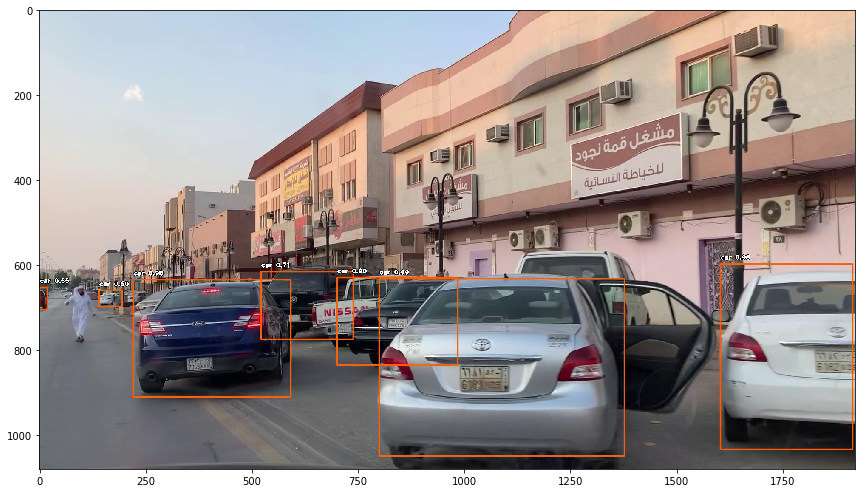

1/2 Completed. Just tested Image: frame79


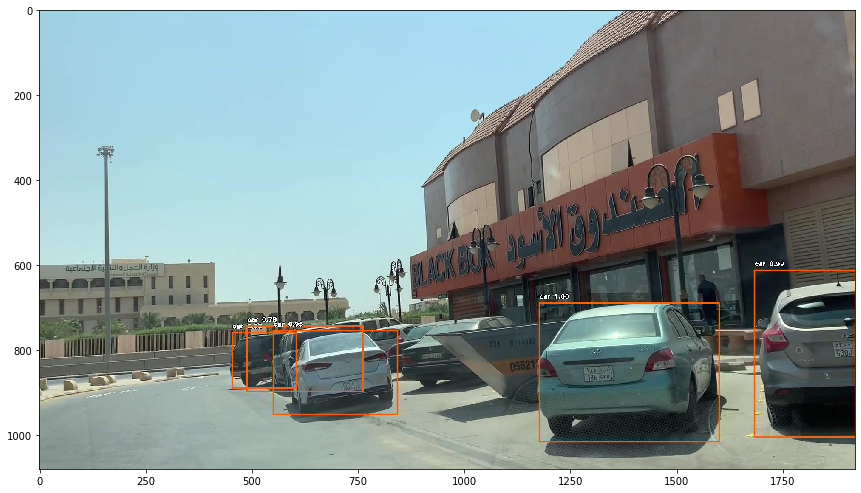

2/2 Completed. Just tested Image: frame312


,ImageId,PredictionString
0,frame79,0.14 1.05 -1.56 3.81 5.68 19.17 0.55 0.12 -3.6...
1,frame312,0.14 -0.06 -4.06 -3.0 9.16 48.46 0.68 0.13 1.4...


In [13]:
MODEL_FILE = 'model_cnn_data-1000000_epochs-100'
PREDICTION_MODEL = os.path.join(MODELS_DIR, MODEL_FILE+'.h5')

model_h5 = PREDICTION_MODEL # Our model's h5 file
images_dir =  os.path.join(DATASET_DIR, 'personal/') # Directory in which images are present for test
masks_dir = None # Binary masks directory if present, set None otherwise

df_submission = test_images_on_dir(model_h5=model_h5,images_dir=images_dir,masks_dir=masks_dir,hide_own_bonnet=False,show_detected_img=True)

df_submission.to_csv(os.path.join(SUBMISSION_DIR, f"submission_rows-{len(df_submission.index)}_model-{MODEL_FILE}.csv"),index=False)
display(df_submission)